In [1]:
import pandas as pd
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error


**Data Loading and Preprocessing:**

In [3]:
drive.mount('/content/drive')

df = pd.read_parquet("/content/drive/MyDrive/True_Becon assignment/data.parquet")

df = df.dropna()
df = df.between_time('09:15', '15:30')
def check_data_types(df):
  print(df.dtypes)

check_data_types(df.copy())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
banknifty    float64
nifty        float64
tte            int32
dtype: object


**Spread and P/L Calculation:**

In [4]:
# Calculating spread
df['spread'] = df['banknifty'] - df['nifty']

# P/L formula
def calculate_pl(spread_diff, position):
  return spread_diff * (df['tte'] ** 0.7) * position

# Calculating P/L for visualization
df['temp_pl'] = df['spread'].diff() * df['tte'] ** 0.7


**Z-Score Model:**

In [5]:
def calculate_zscore(df, window):
  return (df['spread'] - df['spread'].rolling(window=window).mean()) / df['spread'].rolling(window=window).std()

# Defining window size for z-score calculation
window_size = 20

# Calculating z-score
df['z_score'] = calculate_zscore(df.copy(), window_size)

# Defining thresholds for entry and exit signals
threshold_zscore_long = -1.0
threshold_zscore_short = 1.0

def calculate_zscore_position(df, threshold_long, threshold_short):
  return np.where(df['z_score'] < threshold_long, 1, np.where(df['z_score'] > threshold_short, -1, 0))

# Generating trading signals based on z-score
df['long_signal_zscore'] = np.where(df['z_score'] < threshold_zscore_long, 1, 0)
df['short_signal_zscore'] = np.where(df['z_score'] > threshold_zscore_short, -1, 0)


**Z Score Visualization**

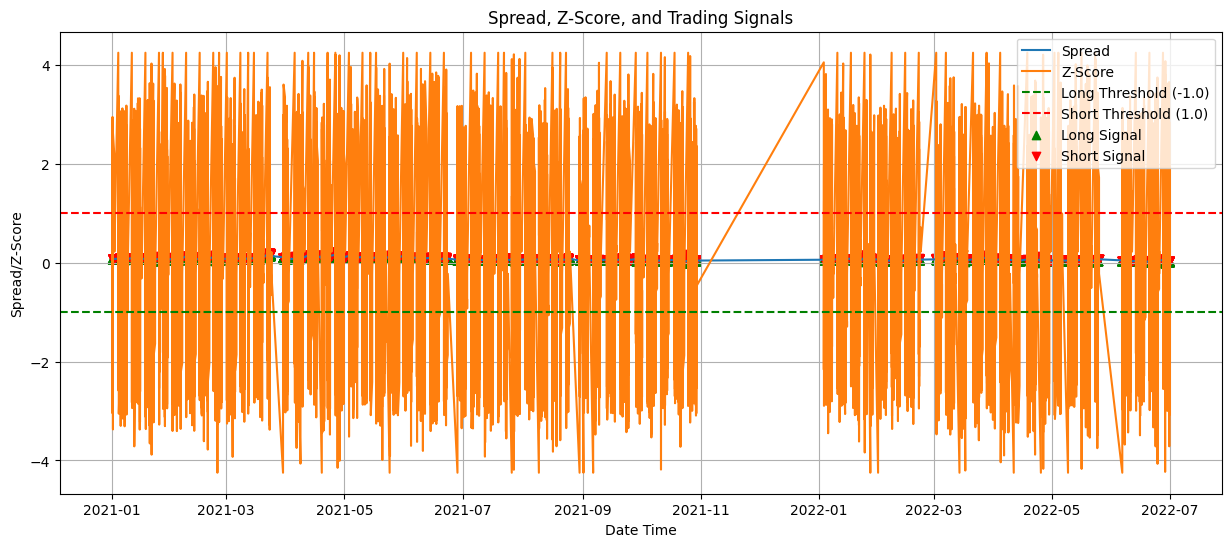

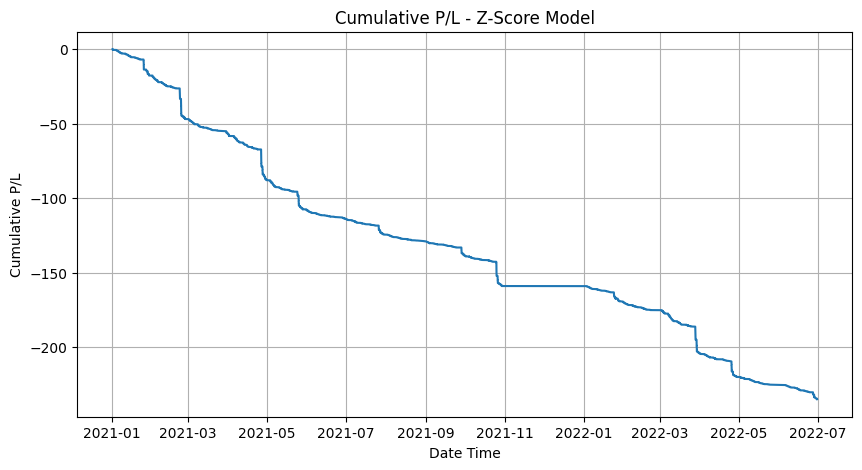

In [7]:
# Plotting spread, z-score, and trading signals
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['spread'], label='Spread')
plt.plot(df.index, df['z_score'], label='Z-Score')
plt.axhline(y=threshold_zscore_long, color='green', linestyle='--', label=f'Long Threshold ({threshold_zscore_long})')
plt.axhline(y=threshold_zscore_short, color='red', linestyle='--', label=f'Short Threshold ({threshold_zscore_short})')
plt.scatter(df.loc[df['long_signal_zscore'] == 1].index, df['spread'][df['long_signal_zscore'] == 1], marker='^', color='green', label='Long Signal')
plt.scatter(df.loc[df['short_signal_zscore'] == -1].index, df['spread'][df['short_signal_zscore'] == -1], marker='v', color='red', label='Short Signal')
plt.title('Spread, Z-Score, and Trading Signals')
plt.xlabel('Date Time')
plt.ylabel('Spread/Z-Score')
plt.legend()
plt.grid(True)
plt.show()

# Cumulative P/L for Z-Score Model
daily_pl_zscore = calculate_pl(df['spread'].diff(), df['long_signal_zscore'])
df_zscore_pl = pd.DataFrame({'daily_pl': daily_pl_zscore}).cumsum()
plt.figure(figsize=(10, 5))
plt.plot(df_zscore_pl.index, df_zscore_pl['daily_pl'], label='Z-Score Model P/L')
plt.title('Cumulative P/L - Z-Score Model')
plt.xlabel('Date Time')
plt.ylabel('Cumulative P/L')
plt.grid(True)
plt.show()

**Random Forest Model:**

In [8]:
df['spread_ma'] = df['spread'].rolling(window=5).mean()
df['spread_std'] = df['spread'].rolling(window=5).std()
df['tte_squared'] = df['tte'] ** 2

df.dropna(inplace=True)

# Defining features and target variable
features = ['spread', 'spread_ma', 'spread_std', 'tte', 'tte_squared']
target = 'spread'

def calculate_pl_zscore(df, threshold):
    df['position'] = np.where(df['z_score'] < -threshold, 1, np.where(df['z_score'] > threshold, -1, 0))
    df['position'] = df['position'].shift()
    df['daily_pl'] = df['spread'].diff() * df['position']
    return df

# Function to calculate P/L for the Random Forest model
def calculate_pl_random_forest(df, rf_model, threshold_long, threshold_short):
    df['predicted_spread'] = rf_model.predict(df[features])
    df['long_signal'] = np.where(df['predicted_spread'] > threshold_long, 1, 0)
    df['short_signal'] = np.where(df['predicted_spread'] < threshold_short, -1, 0)

    df['position'] = df['long_signal'] + df['short_signal']
    df['position'] = df['position'].shift()
    df['daily_pl'] = df['spread'].diff() * df['position']

    return df



# Function to train and evaluate Random Forest model
def train_evaluate_rf(X_train, X_test, y_train, y_test):
  rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
  rf_model.fit(X_train, y_train)
  y_pred = rf_model.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  print(f"Random Forest MSE: {mse}")
  return rf_model

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Train
X_train


,spread,spread_ma,spread_std,tte,tte_squared
time,,,,,
2022-05-16 13:34:00,0.043608,0.042775,0.002119,10,100
2021-05-04 12:07:00,0.106267,0.110385,0.002898,23,529
2021-07-14 10:17:00,0.054805,0.055225,0.000280,15,225
2021-06-22 12:28:00,0.082952,0.084582,0.002030,2,4
2022-05-24 13:00:00,0.050457,0.051649,0.000913,2,4
...,...,...,...,...,...
2022-01-14 11:26:00,0.078437,0.077705,0.000477,13,169
2022-06-15 13:12:00,0.036844,0.036200,0.000469,15,225
2022-05-11 10:42:00,0.040742,0.040865,0.001108,15,225


**Comparisons and Visualization**

<ipython-input-9-557714490fbc>:49: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = df['daily_pl'].mean() / df['daily_pl'].std()


Base Z-Score Model:
Total P/L: 46.794352849999996
Sharpe Ratio: 0.12428119394963918
Max Drawdown: -0.05355049999999295

Enhanced Random Forest Model:
Total P/L: 0.0
Sharpe Ratio: nan
Max Drawdown: 0.0


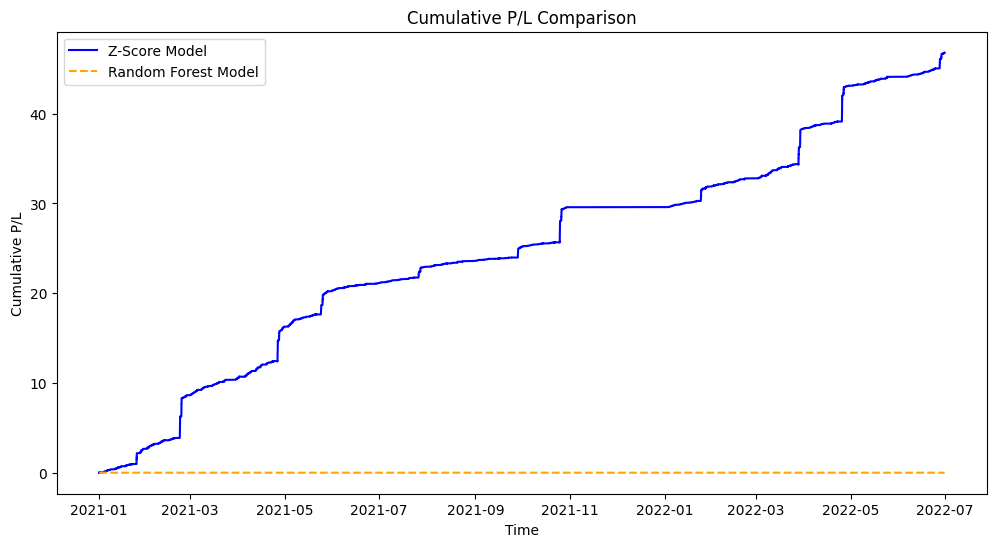

In [9]:

def calculate_pl_zscore(df):
    df['position'] = np.where(df['z_score'] < -threshold, 1, np.where(df['z_score'] > threshold, -1, 0))
    df['position'] = df['position'].shift()
    df['daily_pl'] = df['spread'].diff() * df['position']
    return df


def calculate_pl_random_forest(df, rf_model, threshold_long, threshold_short):
    df['predicted_spread'] = rf_model.predict(df[features])
    df['long_signal'] = np.where(df['predicted_spread'] > threshold_long, 1, 0)
    df['short_signal'] = np.where(df['predicted_spread'] < threshold_short, -1, 0)

    df['position'] = df['long_signal'] + df['short_signal']
    df['position'] = df['position'].shift()
    df['daily_pl'] = df['spread'].diff() * df['position']

    return df

# Base z-score model
threshold = 1.0
df_zscore = df.copy()
df_zscore = calculate_pl_zscore(df_zscore)

# Enhanced Random Forest model
threshold_long_rf = 0.5
threshold_short_rf = -0.5
df_rf = df.copy()

df_rf['spread_ma'] = df_rf['spread'].rolling(window=5).mean()
df_rf['spread_std'] = df_rf['spread'].rolling(window=5).std()
df_rf['tte_squared'] = df_rf['tte'] ** 2
df_rf.dropna(inplace=True)

# Split the data into training and testing sets for Random Forest
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(df_rf[features], df_rf[target], test_size=0.2, random_state=42)

# Train a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

df_rf = calculate_pl_random_forest(df_rf, rf_model, threshold_long_rf, threshold_short_rf)

# Performance metrics
def calculate_performance_metrics(df):
    total_pl = df['daily_pl'].sum()
    sharpe_ratio = df['daily_pl'].mean() / df['daily_pl'].std()

    # Drawdown calculation
    df['cumulative_pl'] = df['daily_pl'].cumsum()
    df['drawdown'] = df['cumulative_pl'] - df['cumulative_pl'].cummax()
    max_drawdown = df['drawdown'].min()

    return total_pl, sharpe_ratio, max_drawdown

# Calculating performance metrics for the z-score model
total_pl_zscore, sharpe_ratio_zscore, max_drawdown_zscore = calculate_performance_metrics(df_zscore)

# Calculating performance metrics for the Random Forest model
total_pl_rf, sharpe_ratio_rf, max_drawdown_rf = calculate_performance_metrics(df_rf)

# Comparing performance metrics
print("Base Z-Score Model:")
print(f"Total P/L: {total_pl_zscore}")
print(f"Sharpe Ratio: {sharpe_ratio_zscore}")
print(f"Max Drawdown: {max_drawdown_zscore}")

print("\nEnhanced Random Forest Model:")
print(f"Total P/L: {total_pl_rf}")
print(f"Sharpe Ratio: {sharpe_ratio_rf}")
print(f"Max Drawdown: {max_drawdown_rf}")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(df_zscore.index, df_zscore['cumulative_pl'], label='Z-Score Model', color='blue')
plt.plot(df_rf.index, df_rf['cumulative_pl'], label='Random Forest Model', color='orange', linestyle='--')
plt.title('Cumulative P/L Comparison')
plt.xlabel('Time')
plt.ylabel('Cumulative P/L')
plt.legend()
plt.show()